### Análisis del sentimiento de los comentarios utilizando un modelo preentrenado.

In [ ]:
import ast
import pandas as pd
from tqdm import tqdm
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor

tqdm.pandas()

#modelo preentrenado
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

#Pasar los comentarios de string a lista
def parse_comments(comment_str):
    try:
        return ast.literal_eval(comment_str)
    except (ValueError, SyntaxError):
        return []


def analyze_sentiment_bert(comment):
    if not comment.strip():
        return 0x

    truncated_comment = comment[:500]  # Truncamos a 500 caracteres porque el modelo da problemas con más
    result = sentiment_pipeline(truncated_comment)[0]
    score = result["label"]  
    return int(score[0]) - 3
#Esta función toma un comentario de texto como entrada y devuelve un valor numérico que representa su sentimiento:
#Negativo → valores entre -2 y -1
#Neutro → 0
#Positivo → valores entre 1 y 2


file_path = "//Users/iclon/Documents/HAB_proyecto_7/meneame_comments_3.csv"
df = pd.read_csv(file_path)

# Convertir la columna de comentarios a listas reales
df["parsed_comments"] = df["top_10_comments"].apply(parse_comments)

# Función para procesar una noticia (paralelizable)
def process_news(comments):
    return sum(analyze_sentiment_bert(c) for c in comments) / len(comments) if comments else 0

# Procesar en paralelo usando ThreadPoolExecutor para tardar menos
with ThreadPoolExecutor() as executor:
    df["sentiment_score"] = list(tqdm(executor.map(process_news, df["parsed_comments"]), total=len(df)))


df[["news_id", "sentiment_score"]].to_csv("sentiment_analysis_results_3.csv", index=False)

print("Análisis de sentimiento completado. Resultados guardados en 'sentiment_analysis_results_3.csv'.")




Device set to use cpu
100%|██████████| 87191/87191 [11:06:19<00:00,  2.18it/s]  

Análisis de sentimiento completado. Resultados guardados en 'sentiment_analysis_results_3.csv'.


### Comprobación visual de la lógica del modelo:

In [43]:

pd.set_option('display.max_colwidth', None)

sentiment_df = pd.read_csv('//Users/iclon/Documents/HAB_proyecto_7/meneame_comments_3.csv')
meneame_df = pd.read_csv('//Users/iclon/Documents/HAB_proyecto_7/sentiment_analysis_with_clicks.csv')

display(sentiment_df.head(25))
display(meneame_df.head(25))


news_id  \
0   1170061   
1   1169886   
2   1170011   
3   1169516   
4   1169786   
5   1169944   
6   1169341   
7   1169976   
8   1169666   
9   1169439   
10  1168706   
11  1168596   
12  1169535   
13  1169761   
14  1168695   
15  1169609   
16  1169655   
17  1168328   
18  1169625   
19  1169472   
20  1168923   
21  1169498   
22  1169330   
23  1168931   
24  1168984   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

,news_id,sentiment_score,clicks
0,1170061,-1.1,1568
1,1169886,-0.1,6855
2,1170011,-0.6,6636
3,1169516,-0.4,8583
4,1169786,-1.3,1392
5,1169944,-1.0,3003
6,1169341,-2.0,1008
7,1169976,-1.4,747
8,1169666,1.1,7592
9,1169439,-0.6,674


#### Unión de la columna clicks al nuevo archivo para analizar la relación

In [ ]:
import pandas as pd


sentiment_df = pd.read_csv('/Users/iclon/Documents/HAB_proyecto_7/sentiment_analysis_results_3.csv')
meneame_df = pd.read_csv('/Users/iclon/Documents/HAB_proyecto_7/meneame_scraped_final_3.csv')


merged_df = sentiment_df.merge(meneame_df[['news_id', 'clicks']], on='news_id', how='left')


output_path = '/Users/iclon/Documents/HAB_proyecto_7/sentiment_analysis_with_clicks.csv'
merged_df.to_csv(output_path, index=False)

print(f"Archivo guardado en: {output_path}")

Archivo guardado en: /Users/iclon/Documents/HAB_proyecto_7/sentiment_analysis_with_clicks.csv


### Análisis gráfico de la relación entre el número de clicks y el sentimiento de los comentarios

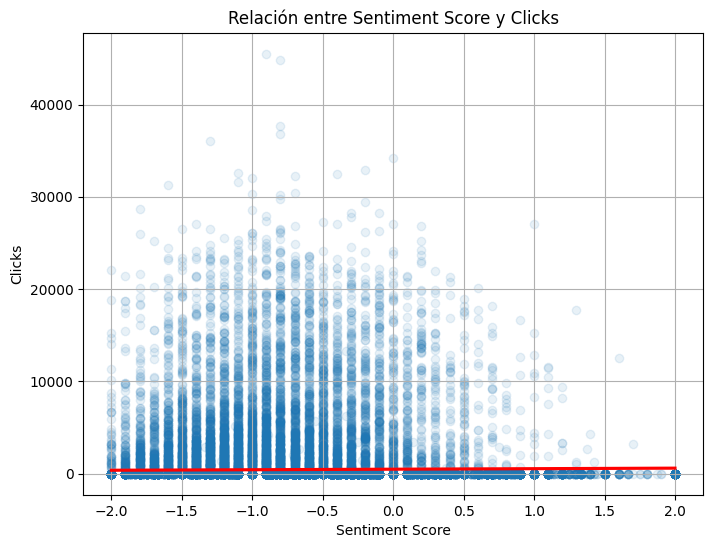

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



file_path = "/Users/iclon/Documents/HAB_proyecto_7/sentiment_analysis_with_clicks.csv"
df = pd.read_csv(file_path)

plt.figure(figsize=(8, 6))
sns.regplot(x=df["sentiment_score"], y=df["clicks"], scatter_kws={"alpha": 0.1}, line_kws={"color": "red"})
plt.xlabel("Sentiment Score")
plt.ylabel("Clicks")
plt.title("Relación entre Sentiment Score y Clicks")
plt.grid(True)
plt.show()

### Conclusión:
El gráfico de dispersión sugiere que no existe una relación clara entre el sentimiento de los comentarios y la cantidad de clicks. Aunque visualmente parece haber una ligera tendencia en la que las noticias con menor número de clicks reciben comentarios más extremos, la dispersión de los datos es alta y no se observa un patrón consistente.

La línea de regresión es prácticamente horizontal, lo que indica que el sentimiento de los comentarios no influye significativamente en la cantidad de clicks que recibe una noticia. Esto sugiere que otros factores, como el título de la noticia, su temática o su difusión en la plataforma, pueden ser más determinantes en la interacción del usuario con el contenido.